TODO:

Discover concepts data:
- sample data from different diseases
- do SLIC on the above data
- resize data for the network input
- collect activations for these resized data along with info on the label/patient id
- do IPCA on activations
- cluster the activations

Get concepts:

PRECONDITION: COLLECT ACTIVATIONS
- get the activations for found concepts in its raw form
- create random counterpart from the whole concepts data
- train binary classifier between the two
- take orthogonal vector as the CAV

Test concepts for the classes:

PRECONDITION: COLLECT ACTIVATIONS AND GRADIENTS
- collect activations for classes and gradients of their logits (gradient with respect to the activations)
- calculate the directional derivative for all of the classes
- calculate the statistical significance of the TCAV score

Interpret concepts from the latent space:
- review all the clusters

### ACTIVATIONS COLLECTION

- concepts data (activations, patch_id, patient_id)
- classes (activations, gradients, patient_id)

In [2]:
from preprocessing import load_dataset
import numpy as np
import pandas as pd
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
import matplotlib.pyplot as plt
from skimage.transform import resize

In [7]:
def get_masks(tab):
    classes = set(tab.flatten())
    masks = [np.zeros(np.shape(tab))]*len(classes)

    for i, cls in enumerate(classes):
        masks[i] = (tab == cls).astype(int) 
    return masks

# https://codereview.stackexchange.com/questions/132914/crop-black-border-of-image-using-numpy
def crop_image(img,tol=0):
    # img is 2D image data
    # tol  is tolerance
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def resize_img(img, new_shape, order=3):
    return resize(img, new_shape, order=order, mode='edge')

def create_discovery_data(numSegments_list=30, concepts_ratio=0.2):
    """Function that creates discovery dataset for DTCAV method
       it takes equal sample from classes (pathologies) and does SLIC to every 
       data point then crop it and rescale to network input size
       
       Args:
           - numSegments_list -> list that contains sizes of segments 
             that are to be discovered
           - concepts_ratio   -> ratio that defines the amount of 
             samples considered for creating the dataset
             
        Returns:
           - output_data -> dictionary of all concept images found, 
             data - contains images, patient_ids - contains patient ids,
             pathologies contains list with pathologies corresponding to sample
           
        """
    
    if type(numSegments_list) is int:
        numSegments_list = [numSegments_list]
    
    data = load_dataset()
    pathologies = set([data[x]['pathology'] for x in data])
    dcm = [x for x in data if data[x]['pathology'] == 'DCM']
    hcm = [x for x in data if data[x]['pathology'] == 'HCM']
    minf = [x for x in data if data[x]['pathology'] == 'MINF']
    nor = [x for x in data if data[x]['pathology'] == 'NOR']
    rv = [x for x in data if data[x]['pathology'] == 'RV']

    paths = [dcm, hcm, minf, nor, rv]
    types = ["DCM", "HCM", "MINF", "NOR", "RV"]
    sample = []
    sample_type = []
    all_samples = len(data)
    output_data = []            
    
    while len(sample)/all_samples <= concepts_ratio:
        print(len(sample)/all_samples)
        for i, x in enumerate(paths):
            smpl = np.random.choice(x)
            sample.append(smpl)
            sample_type.append(types[i])
            print(len(sample)/all_samples)

            for typ in ['ed_data', 'es_data']:
                for slice_ in data[smpl][typ]:
                    image = img_as_float(slice_.astype(float))
                    # we can do different levels of superpixels
                    for i, numSegments in enumerate(numSegments_list):
                        segments = slic(image, compactness=0.1, n_segments=numSegments, sigma = 5)
                        masks = get_masks(segments)

                        # probably for every superpixel found
                        for supix in masks:
                            im = crop_image(supix)
                            output_data.append(resize_img(im, (348,348)))
            np.save('patient{}_patches_{}segments_{}_path_{}'.format(sample[-1], numSegments,i,types[i]), output_data[-1])                      

    return {'data':output_data, 'patients_ids':sample, 'pathologies':sample_type}

In [8]:
out = create_discovery_data()

0.0
0.01
0.02
0.03
0.04
0.05
0.05
0.06
0.07
0.08
0.09
0.1
0.1
0.11
0.12
0.13
0.14
0.15
0.15
0.16
0.17
0.18
0.19
0.2
0.2
0.21
0.22
0.23
0.24
0.25


In [18]:
len(out['data'])

9912

In [2]:
data = load_dataset()

In [15]:
data[1].keys()

dict_keys(['height', 'weight', 'pathology', 'ed_data', 'ed_gt', 'es_data', 'es_gt'])

In [6]:
pathologies = set([data[x]['pathology'] for x in data])

In [7]:
pathologies

{'DCM', 'HCM', 'MINF', 'NOR', 'RV'}

In [12]:


dcm = [x for x in data if data[x]['pathology'] == 'DCM']
hcm = [x for x in data if data[x]['pathology'] == 'HCM']
minf = [x for x in data if data[x]['pathology'] == 'MINF']
nor = [x for x in data if data[x]['pathology'] == 'NOR']
rv = [x for x in data if data[x]['pathology'] == 'RV']

paths = [dcm, hcm, minf, nor, rv]

In [28]:


for x in paths:
    sample = np.random.choice(x)
image = img_as_float(data[sample]['ed_data'][0].astype(float))
 
#for i, numSegments in enumerate((10, 50, 70, 100, 200, 300)):
numSegments = 30
segments = slic(image, compactness=0.1, n_segments = numSegments, sigma = 5)
print(segments)

[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [18 18 18 ... 17 17 17]
 [18 18 18 ... 17 17 17]
 [18 18 18 ... 17 17 17]]


In [29]:
np.shape(segments)

(204, 296)

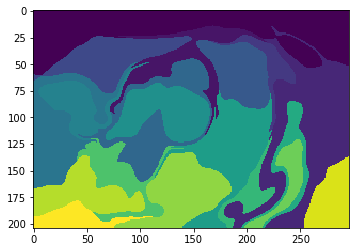

In [30]:
plt.imshow(segments)
plt.show()

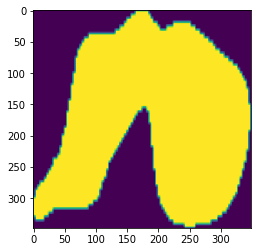

In [84]:

masks = get_masks(segments)
im = crop_image(masks[9])
im2 = resize(im, (348,348))
plt.imshow(im2)
plt.show()

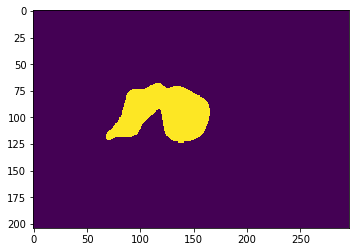

In [62]:
plt.imshow(masks[9])
plt.show()

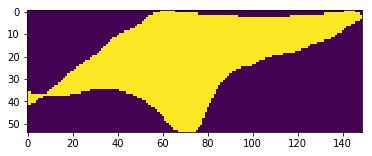

In [69]:
im = crop_image(masks[4])
plt.imshow(im)
plt.show()